# Uplift modelling

An complex example of how heterogeneous treatment effects are used in ecommerce platforms. 🚀🚀🚀

**The business problem:**

We are concerted with *giving or not giving users a 5% discount voucher*.

If we give it to everyone, we'll likely get more bookings, but at the same time we hurt our margins. So the best way to proceed is to give the coupons only to those customers that were unsure about the decision and that will actually convert after receiving it. Also, not giving the coupons to customers that were already going to book something no matter what!

**The causal problem:**

Our treatment $T$ is offering customers this coupon, a binary variable.

Our outcome $Y$ is the customer finalizing their booking or not, also a binary variable.

Additionally, we have access to a number of other variables $X$ characterizing the user, the channel that brough them to the platform, the specific ongoing session, and so on... We believe some of them could be valuable in deciding the effectiveness of the intervention. In other words, the effect isn't uniform but varies depending on some of these factors.

In [ ]:
import warnings
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

np.random.seed(111)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.plotting_context("notebook")

### Define the simulation mechanism

Two settings are possible: "observational" and "rct". In the former, samples are not balanced, whereas in the latter, they are. 

In [ ]:
def data_generating_process(
    n: int, 
    setting: str, 
    seed: int = 123,
) -> pd.DataFrame:
    """Generate a synthetic dataset for uplift modeling in a lodging marketplace.

    Args:
        n: number of samples
        setting: "observational" (targeted, unbalanced) or "rct" (balanced 50/50)
        seed: the random seed

    Returns:
        data: The actual dataset used for modeling, with the following columns:
            - client_id: unique identifier for each sample
            - Y: conversion result [binary, 0/1]
            - T: treatment [binary, 0/1]
            - Various features commonly available on ecommerce platforms
        meta_data: Information NOT available in practice, but useful for validation:
            - client_id: unique identifier for each sample
            - Y: conversion result [binary, 0/1]
            - T: treatment [binary, 0/1]
            - p_treat: treatment propensity used in generation
            - true_p_y0: conversion probability if untreated 
            - true_p_y1: conversion probability if treated
            - true_uplift: true individual uplift (p_y1 - p_y0)
    """
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    rng = np.random.default_rng(seed)

    channels = np.array(["paid_search", "organic", "email", "direct", "app_push"])
    devices = np.array(["mobile_web", "desktop", "app"])
    dest_tiers = np.array(["tier1", "tier2", "tier3"])

    # --- Draw base features ---
    channel = rng.choice(channels, size=n, p=[0.35, 0.25, 0.15, 0.20, 0.05])
    device = rng.choice(devices, size=n, p=[0.55, 0.30, 0.15])
    dest_tier = rng.choice(dest_tiers, size=n, p=[0.50, 0.35, 0.15])

    # Lead time (days to check-in): empirical-ish discrete distribution
    lead_time = np.clip(
        rng.choice(
            [0, 1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90, 120],
            size=n,
            p=[0.06, 0.05, 0.05, 0.05, 0.07, 0.07, 0.08, 0.09, 0.11, 0.12, 0.09, 0.07, 0.05, 0.04],
        ),
        0,
        120,
    )

    # Funnel depth: 0=landing, 1=search, 2=property details, 3=checkout
    funnel_depth = rng.choice([0, 1, 2, 3], size=n, p=[0.25, 0.40, 0.28, 0.07])

    # Behavioral/identity features
    price_sort_used = rng.binomial(1, p=0.35 + 0.15 * (channel == "paid_search"))
    past_coupon_user = rng.binomial(1, p=0.25 + 0.10 * (channel == "email"))
    tenure_days = rng.integers(0, 1800, size=n)
    hour_local = rng.integers(0, 24, size=n)

    # Recent ad exposure (helps form confounding in observational setting)
    recent_ad_exposure = rng.binomial(1, p=0.20 + 0.25 * (channel == "paid_search"))

    # --- Treatment assignment ---
    if setting == "observational":
        # Higher propensity for price-sensitive & shallow-funnel sessions, paid channels, recent exposure
        logit_p_treat = (
            -1.0
            + 1.2 * (channel == "paid_search")
            + 0.6 * (channel == "email")
            + 0.5 * (price_sort_used == 1)
            + 0.4 * (past_coupon_user == 1)
            + 0.5 * (funnel_depth == 0)
            + 0.3 * (funnel_depth == 1)
            - 0.3 * (funnel_depth == 3)
            + 0.2 * ((lead_time >= 8) & (lead_time <= 60))
            + 0.8 * (recent_ad_exposure == 1)
            - 0.2 * (device == "app")
        )
        p_treat = sigmoid(logit_p_treat)
        T = rng.binomial(1, p_treat)
    elif setting == "rct":
        p_treat = np.full(n, 0.5)
        T = rng.binomial(1, 0.5, size=n)
    else:
        raise ValueError("setting must be 'observational' or 'rct'")

    # --- Outcome model (potential outcomes) ---
    # Lead-time buckets for nonlinearity
    lt_0_1 = (lead_time <= 1).astype(float)
    lt_2_7 = ((lead_time >= 2) & (lead_time <= 7)).astype(float)
    lt_8_30 = ((lead_time >= 8) & (lead_time <= 30)).astype(float)
    lt_31_90 = ((lead_time >= 31) & (lead_time <= 90)).astype(float)
    lt_91_120 = ((lead_time >= 91) & (lead_time <= 120)).astype(float)

    # Baseline conversion log-odds (no coupon)
    baseline_logit = (
        -3.5
        + 0.2 * (device == "desktop")
        + 0.1 * (device == "app")
        + 0.4 * (dest_tier == "tier1")
        + 0.2 * (dest_tier == "tier2")
        + 0.15 * lt_0_1
        + 0.05 * lt_2_7
        + 0.0 * lt_8_30
        - 0.05 * lt_31_90
        - 0.1 * lt_91_120
        + 0.5 * (funnel_depth == 1)
        + 1.2 * (funnel_depth == 2)
        + 2.0 * (funnel_depth == 3)
        + 0.0002 * tenure_days
        + 0.05 * np.cos(2 * np.pi * hour_local / 24.0)
    )

    # True treatment effect on log-odds (uplift_logit): depends on realistic, not all, features
    uplift_logit = (
        0.45 * (price_sort_used == 1)
        + 0.35 * (channel == "paid_search")
        + 0.20 * (channel == "email")
        + 0.25 * ((lead_time >= 8) & (lead_time <= 60))
        + 0.20 * (funnel_depth == 0)
        + 0.15 * (funnel_depth == 1)
        - 0.05 * (funnel_depth == 3)
        + 0.10 * (past_coupon_user == 1)
        - 0.08 * (device == "app")  # app users a bit less elastic
        + 0.05
        * ((price_sort_used == 1) & ((lead_time >= 8) & (lead_time <= 60)))  # mild interaction
    )

    # Mild idiosyncratic noise
    rng_noise = np.random.default_rng(seed + 13)
    uplift_logit += rng_noise.normal(0, 0.05, size=n)

    # Potential outcomes
    logit_y0 = baseline_logit
    logit_y1 = baseline_logit + uplift_logit
    p_y0 = sigmoid(logit_y0)
    p_y1 = sigmoid(logit_y1)

    # Realized outcome given treatment
    Y = rng.binomial(1, np.where(T == 1, p_y1, p_y0))

    data = pd.DataFrame(
        {
            "client_id": np.arange(n),
            "Y": Y,
            "T": T,
            "channel": channel,
            "device": device,
            "lead_time": lead_time,
            "funnel_depth": funnel_depth,
            "price_sort_used": price_sort_used,
            "past_coupon_user": past_coupon_user,
            "tenure_days": tenure_days,
            "dest_tier": dest_tier,
            "hour_local": hour_local,
            "recent_ad_exposure": recent_ad_exposure,
        }
    )
    meta_data = pd.DataFrame(
        {
            "client_id": np.arange(n),
            "Y": Y,
            "T": T,
            "p_treat": p_treat,
            "true_p_y0": p_y0,
            "true_p_y1": p_y1,
            "true_uplift": p_y1 - p_y0,
        }
    )
    return data, meta_data


In [ ]:
# Observational (targeted / unbalanced)
obs_df = data_generating_process(60_000, setting="observational", seed=11)

# Randomized experiment (balanced 50/50)
rct_df = data_generating_process(60_000, setting="rct", seed=12)

# Quick sanity checks
print("Observational:")
print("  n =", len(obs_df))
print("  treat_rate =", obs_df["T"].mean().round(4))
print("  conv_rate_T1 =", obs_df.loc[obs_df["T"] == 1, "Y"].mean().round(4))
print("  conv_rate_T0 =", obs_df.loc[obs_df["T"] == 0, "Y"].mean().round(4))

print("\nRCT:")
print("  n =", len(rct_df))
print("  treat_rate =", rct_df["T"].mean().round(4))
print("  conv_rate_T1 =", rct_df.loc[rct_df["T"] == 1, "Y"].mean().round(4))
print("  conv_rate_T0 =", rct_df.loc[rct_df["T"] == 0, "Y"].mean().round(4))

Observational:
  n = 60000
  treat_rate = 0.574
  conv_rate_T1 = 0.1794
  conv_rate_T0 = 0.1123

RCT:
  n = 60000
  treat_rate = 0.5012
  conv_rate_T1 = 0.1737
  conv_rate_T0 = 0.1076


In [7]:
rct_df

,Y,T,p_treat,channel,device,lead_time,funnel_depth,price_sort_used,past_coupon_user,tenure_days,dest_tier,hour_local,recent_ad_exposure,true_p_y0,true_p_y1,true_uplift
0,0,1,0.5,paid_search,mobile_web,30,1,0,0,1337,tier1,17,0,0.087421,0.171102,0.083681
1,1,1,0.5,direct,mobile_web,0,3,0,0,526,tier2,21,1,0.267089,0.257368,-0.009720
2,0,1,0.5,paid_search,desktop,120,0,0,0,1080,tier1,5,1,0.058908,0.095553,0.036645
3,0,0,0.5,paid_search,desktop,21,1,0,0,1660,tier1,0,0,0.117326,0.200716,0.083390
4,0,0,0.5,paid_search,mobile_web,120,1,0,0,1588,tier3,17,0,0.057576,0.091587,0.034011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0.5,email,app,21,1,1,0,1031,tier1,11,0,0.087696,0.208333,0.120637
59996,0,1,0.5,organic,app,7,0,1,0,815,tier1,18,0,0.058031,0.099992,0.041962
59997,0,1,0.5,email,mobile_web,21,1,1,1,1581,tier3,5,0,0.064715,0.188899,0.124184
59998,0,0,0.5,app_push,app,45,2,0,0,1392,tier3,1,1,0.127494,0.142514,0.015020


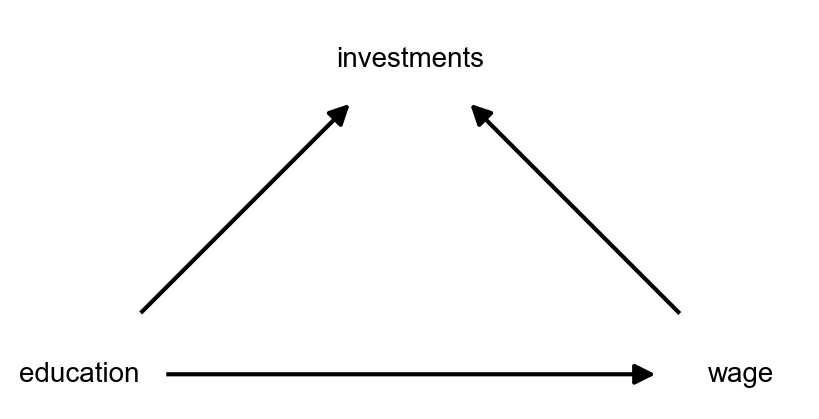

In [ ]:
# ============================================================
# UPLIFT MODELING: T-learner, X-learner, DR-learner (from scratch)
# ============================================================

# -----------------------------
# 0) Common helpers
# -----------------------------
CAT_COLS = ["channel","device","dest_tier"]
NUM_COLS = ["lead_time","funnel_depth","price_sort_used","past_coupon_user",
            "tenure_days","hour_local","recent_ad_exposure"]

def make_preprocessor() -> ColumnTransformer:
    return ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CAT_COLS),
            ("num", "passthrough", NUM_COLS),
        ]
    )

def train_test_split_df(df: pd.DataFrame, test_size=0.25, seed=7):
    X = df[CAT_COLS + NUM_COLS]
    y = df["Y"].astype(int).values
    t = df["T"].astype(int).values
    # keep prop for IPW evaluation if present
    p = df["p_treat"].values if "p_treat" in df.columns else np.full(len(df), 0.5)
    return train_test_split(X, y, t, p, test_size=test_size, random_state=seed, stratify=t)

# Simple propensity model (for observational data)
def fit_propensity(X, t) -> Pipeline:
    pre = make_preprocessor()
    prop = Pipeline([
        ("pre", pre),
        ("logit", LogisticRegression(max_iter=300))
    ])
    prop.fit(X, t)
    return prop

# -----------------------------
# 1) T-learner
# -----------------------------
def fit_t_learner(X_train, y_train, t_train) -> Tuple[Pipeline, Pipeline]:
    pre = make_preprocessor()
    clf1 = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=7))])  # Y|T=1
    clf0 = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=7))])  # Y|T=0
    clf1.fit(X_train[t_train==1], y_train[t_train==1])
    clf0.fit(X_train[t_train==0], y_train[t_train==0])
    return clf1, clf0

def predict_uplift_t_learner(clf1, clf0, X) -> np.ndarray:
    p1 = clf1.predict_proba(X)[:,1]
    p0 = clf0.predict_proba(X)[:,1]
    return p1 - p0

# -----------------------------
# 2) X-learner
# -----------------------------
def fit_x_learner(X_train, y_train, t_train, prop_model=None) -> Dict[str, Pipeline]:
    # Stage 1: T-learner outcome models
    m1, m0 = fit_t_learner(X_train, y_train, t_train)

    # Impute individual effects
    # D1 for treated: Y - m0(X)
    # D0 for control: m1(X) - Y
    p0_cf = m0.predict_proba(X_train)[:,1]
    p1_cf = m1.predict_proba(X_train)[:,1]
    D1 = y_train - p0_cf    # only meaningful where T=1
    D0 = p1_cf - y_train    # only meaningful where T=0

    # Stage 2: effect models within each group
    pre = make_preprocessor()
    g1 = Pipeline([("pre", pre), ("gbr", GradientBoostingRegressor(random_state=7))])  # for treated group
    g0 = Pipeline([("pre", pre), ("gbr", GradientBoostingRegressor(random_state=7))])  # for control group
    g1.fit(X_train[t_train==1], D1[t_train==1])
    g0.fit(X_train[t_train==0], D0[t_train==0])

    # Propensity model for combination weights (if not provided)
    if prop_model is None:
        prop_model = fit_propensity(X_train, t_train)

    return {"m1": m1, "m0": m0, "g1": g1, "g0": g0, "prop": prop_model}

def predict_uplift_x_learner(x_models: Dict[str, Pipeline], X) -> np.ndarray:
    e = x_models["prop"].predict_proba(X)[:,1]
    # tau_hat1 = g1(X) (good for treated-like points)
    # tau_hat0 = g0(X) (good for control-like points)
    tau1 = x_models["g1"].predict(X)
    tau0 = x_models["g0"].predict(X)
    # Combine with Rubin-style weights w(x) = e(x)
    return e * tau0 + (1.0 - e) * tau1

# -----------------------------
# 3) DR-learner (orthogonal / doubly-robust)
# -----------------------------
def fit_dr_learner(X_train, y_train, t_train, prop_model=None) -> Dict[str, Pipeline]:
    pre = make_preprocessor()
    # Outcome models m_t(x) for t=0,1
    m1 = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=7))])
    m0 = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=7))])
    m1.fit(X_train[t_train==1], y_train[t_train==1])
    m0.fit(X_train[t_train==0], y_train[t_train==0])

    # Propensity
    if prop_model is None:
        prop_model = fit_propensity(X_train, t_train)

    # Build pseudo-outcome (orthogonalized):
    # tau_tilde = ((Y - m_T(X)) * (T - e(X))) / (e(X) * (1 - e(X)))
    mu1 = m1.predict_proba(X_train)[:,1]
    mu0 = m0.predict_proba(X_train)[:,1]
    e = np.clip(prop_model.predict_proba(X_train)[:,1], 1e-3, 1-1e-3)
    muT = np.where(t_train==1, mu1, mu0)
    numer = (y_train - muT) * (t_train - e)
    denom = e * (1 - e)
    tau_tilde = numer / denom

    # Final stage: regress tau_tilde on X with a flexible regressor
    tau_model = Pipeline([("pre", pre), ("gbr", GradientBoostingRegressor(random_state=7))])
    tau_model.fit(X_train, tau_tilde)

    return {"m1": m1, "m0": m0, "prop": prop_model, "tau": tau_model}

def predict_uplift_dr_learner(dr_models: Dict[str, Pipeline], X) -> np.ndarray:
    return dr_models["tau"].predict(X)

# -----------------------------
# 4) Policy curve & AUUC (evaluation)
# -----------------------------
def policy_value_curve(df: pd.DataFrame, tau_hat: np.ndarray, use_ipw: bool) -> pd.DataFrame:
    # Sort by predicted uplift
    d = df.copy()
    d = d.assign(tau_hat=tau_hat).sort_values("tau_hat", ascending=False).reset_index(drop=True)
    n = len(d)
    ks = np.linspace(0.1, 1.0, 10)
    rows = []
    prev_k = 0.0
    prev_auuc = 0.0
    prev_uplift = 0.0

    for k in ks:
        m = int(np.floor(k * n))
        seg = d.iloc[:m]
        if use_ipw:
            e = np.clip(seg["p_treat"].values, 1e-3, 1-1e-3)
            y = seg["Y"].values
            t = seg["T"].values
            w_t = t / e
            w_c = (1 - t) / (1 - e)
            mu_t = np.sum(w_t * y) / np.sum(w_t)
            mu_c = np.sum(w_c * y) / np.sum(w_c)
            uplift = mu_t - mu_c
        else:
            uplift = seg.loc[seg["T"]==1, "Y"].mean() - seg.loc[seg["T"]==0, "Y"].mean()

        auuc = prev_auuc + 0.5*(uplift + prev_uplift)*(k - prev_k)
        rows.append({"k": k, "group_size": m, "uplift_per_user": uplift, "AUUC": auuc})
        prev_k, prev_auuc, prev_uplift = k, auuc, uplift
    return pd.DataFrame(rows)

# -----------------------------
# 5) Example usage
# -----------------------------
if __name__ == "__main__":
    # Example with RCT data (balanced groups)
    # from your generator:
    # rct_df = generate_lodging_uplift_data(60_000, "rct", seed=12)
    # obs_df = generate_lodging_uplift_data(60_000, "observational", seed=11)

    # Replace with one of your dataframes:
    df = rct_df  # or obs_df

    X_tr, X_te, y_tr, y_te, t_tr, t_te = train_test_split_df(df)

    # T-learner
    m1, m0 = fit_t_learner(X_tr, y_tr, t_tr)
    tau_hat_T = predict_uplift_t_learner(m1, m0, X_te)

    # X-learner
    prop_tr = fit_propensity(X_tr, t_tr) if "p_treat" not in df.columns else None
    x_models = fit_x_learner(X_tr, y_tr, t_tr, prop_model=prop_tr)
    tau_hat_X = predict_uplift_x_learner(x_models, X_te)

    # DR-learner
    dr_models = fit_dr_learner(X_tr, y_tr, t_tr, prop_model=prop_tr)
    tau_hat_DR = predict_uplift_dr_learner(dr_models, X_te)

    # Evaluate with policy curves
    test_df = pd.DataFrame({
        "Y": y_te, "T": t_te,
        "p_treat": df.loc[X_te.index, "p_treat"].values if "p_treat" in df.columns else 0.5
    })
    use_ipw = not np.allclose(test_df["p_treat"].values, 0.5)  # Observational -> IPW; RCT -> diff-in-means

    curve_T  = policy_value_curve(test_df, tau_hat_T,  use_ipw=use_ipw)
    curve_X  = policy_value_curve(test_df, tau_hat_X,  use_ipw=use_ipw)
    curve_DR = policy_value_curve(test_df, tau_hat_DR, use_ipw=use_ipw)

    print("Top-k AUUC (T, X, DR):",
          curve_T["AUUC"].iloc[-1].round(4),
          curve_X["AUUC"].iloc[-1].round(4),
          curve_DR["AUUC"].iloc[-1].round(4))

    # Treating the top 30% example (simulate policy value)
    top_k = 0.30
    k_idx = int(np.floor(top_k * len(test_df)))
    order = np.argsort(-tau_hat_DR)  # by DR uplift
    seg = test_df.iloc[order[:k_idx]]
    if use_ipw:
        e = np.clip(seg["p_treat"].values, 1e-3, 1-1e-3)
        y = seg["Y"].values; t = seg["T"].values
        mu_t = np.sum((t/e)*y)/np.sum(t/e)
        mu_c = np.sum(((1-t)/(1-e))*y)/np.sum((1-t)/(1-e))
        print("Top-30% uplift per user (IPW):", (mu_t - mu_c).round(4))
    else:
        print("Top-30% uplift per user (RCT diff-in-means):",
              (seg.loc[seg["T"]==1,"Y"].mean() - seg.loc[seg["T"]==0,"Y"].mean()).round(4))


### Conclusions

TBW